Model architecture and training were discussed in ModelTrainingValidation.ipynb. This notebook focuses on using it for image segmentation, and visualizing its filters.

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Deep Learning homework/Project')
basedir='/content/drive/MyDrive/Deep Learning homework/Project/'

Mounted at /content/drive


First, we will prepare the test images. This is similar to the image processing step in the last notebook.

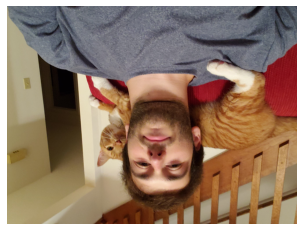

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img, img_to_array

test_dir = "tests/"
test_paths = sorted(
    [os.path.join(test_dir, fname)
    for fname in os.listdir(test_dir)
    if fname.endswith(".jpg")])

plt.axis("off")
#An example of one image
plt.imshow(load_img(test_paths[1]))

In [ ]:
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(test_paths)
random.Random(1337).shuffle(test_paths)
def test_image_path(path):
  return img_to_array(load_img(path, target_size=img_size))

test_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")

for i in range(num_imgs):
  test_imgs[i] = test_image_path(test_paths[i])

testfile=basedir+'array/tests.npy'
np.save(testfile, test_imgs)

In [ ]:
model=keras.models.load_model('oxford_segmentation.keras')

In [ ]:
print(test_imgs.shape)

(11, 200, 200, 3)


We want to display the test images and their predictions on top of each other for easy comparison.

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
def DisplayHorizontal(nparray):
  imgs=[]
  for i in range(nparray.shape[0]):
    imgs.append(nparray[i,:,:,:])
  imgs=cv2.hconcat(imgs)
  cv2_imshow(imgs)

def display_target(nparray):
  imgs=[]
  for i in range(nparray.shape[0]):
    normalized_array = (nparray[i,:,:,:].astype("float32")) * 127
    imgs.append(normalized_array)
  imgs=cv2.hconcat(imgs)
  cv2_imshow(imgs)


1/1 [==============================] - 3s 3s/step


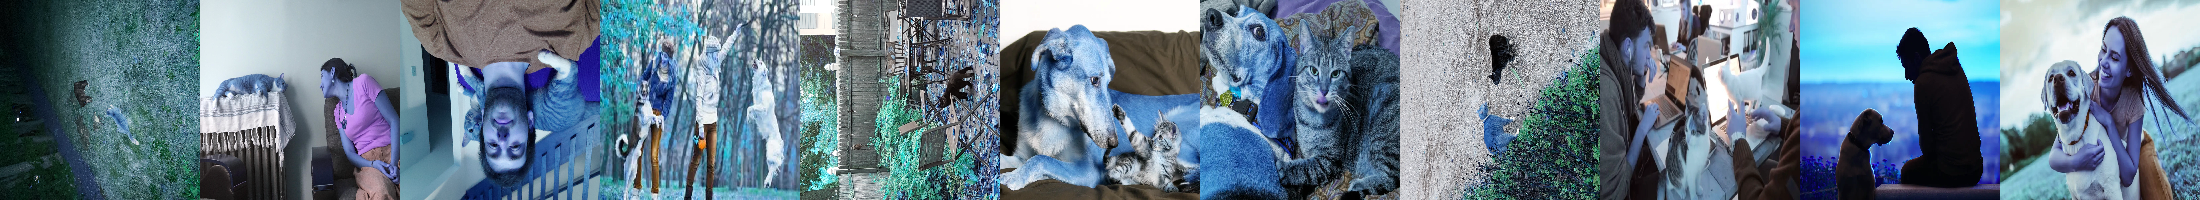

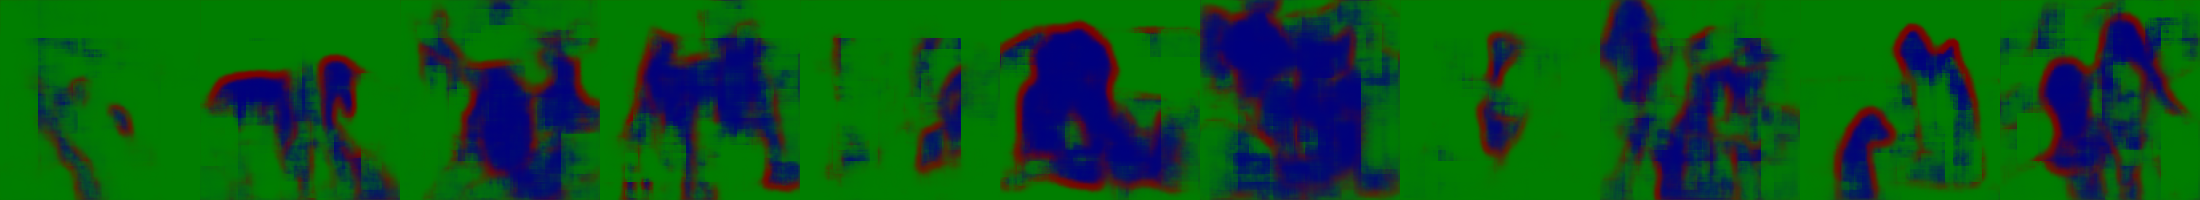

In [ ]:
results=model.predict(test_imgs)
DisplayHorizontal(test_imgs)
display_target(results)

Next, we can visualize filter responses

In [ ]:
for layer in model.layers:
  print(layer.name)


input_1
rescaling
conv2d
conv2d_1
conv2d_2
conv2d_3
conv2d_4
conv2d_5
conv2d_transpose
conv2d_transpose_1
conv2d_transpose_2
conv2d_transpose_3
conv2d_transpose_4
conv2d_transpose_5
conv2d_6


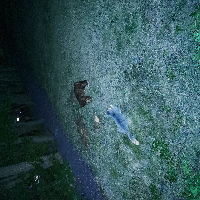

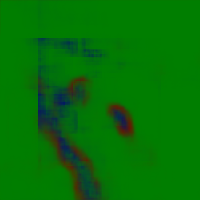

In [ ]:
img=test_imgs[0]
cv2_imshow(test_imgs[0])
normalized_result = (results[0,:,:,:].astype("float32")) * 127
cv2_imshow(normalized_result)

#You can't put one image into a model. You need to turn it into a "batch" of one
img_batch=np.expand_dims(img, axis=0)

This is a good example to analyze, because the model successfully identified the outlines of the two animals in this photo, but it also outlined the patch of dirt (see bottom left)

In [ ]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
  if isinstance(layer, (layers.Conv2D, layers.Conv2DTranspose)):
    layer_outputs.append(layer.output)
    layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)
#This model returns the values of the layer activations in the Segmentation model
#It accepts a pre-processed test image, such as one of the above
activations = activation_model.predict(img_batch)

1/1 [==============================] - 0s 458ms/step


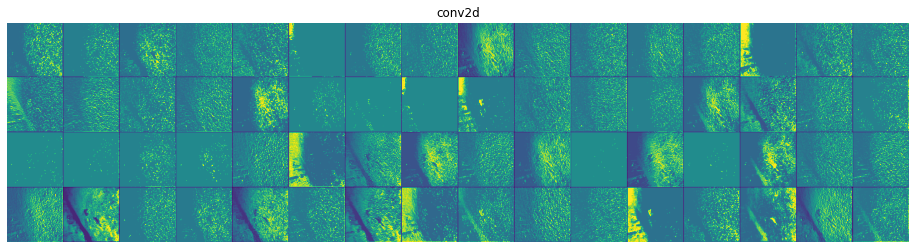

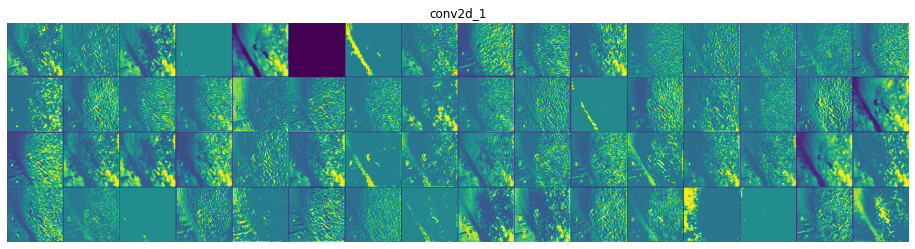

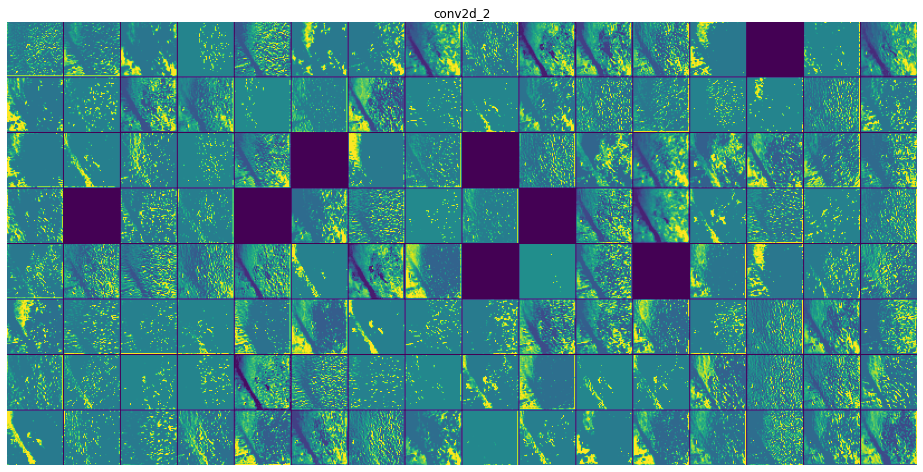

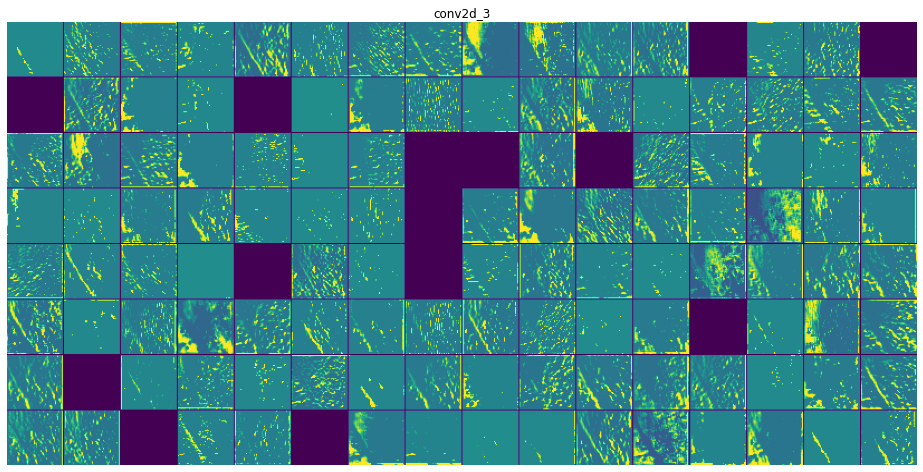

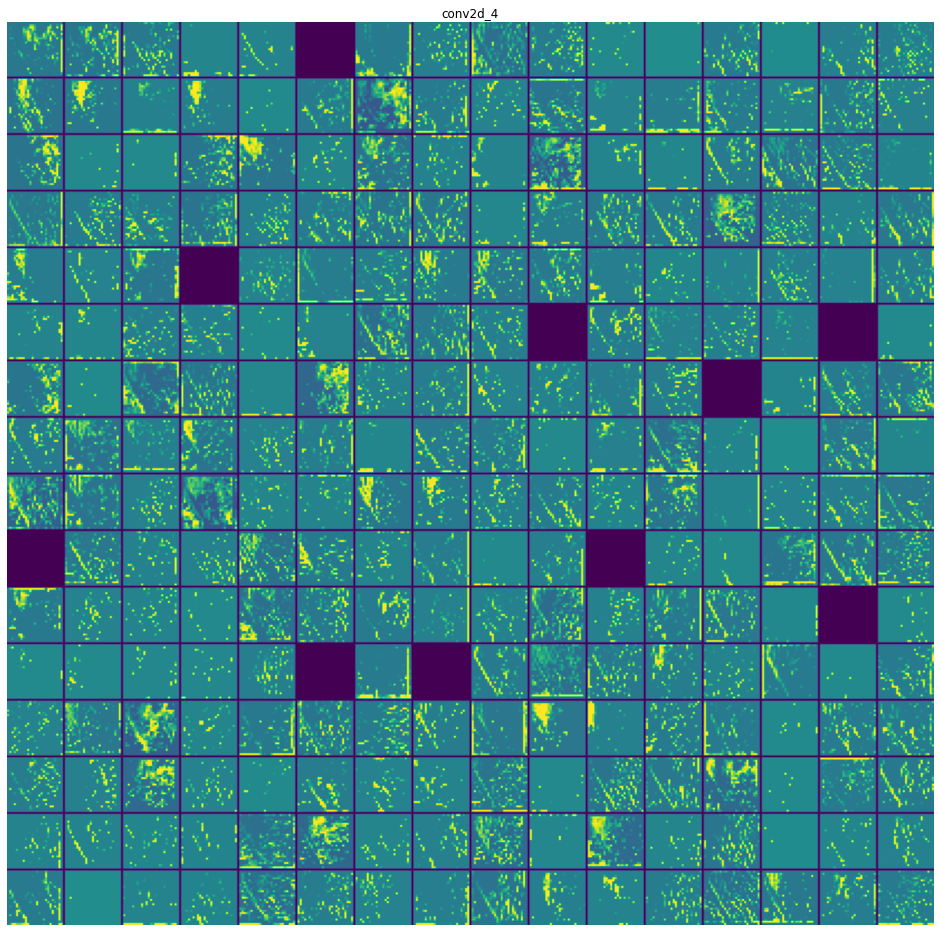

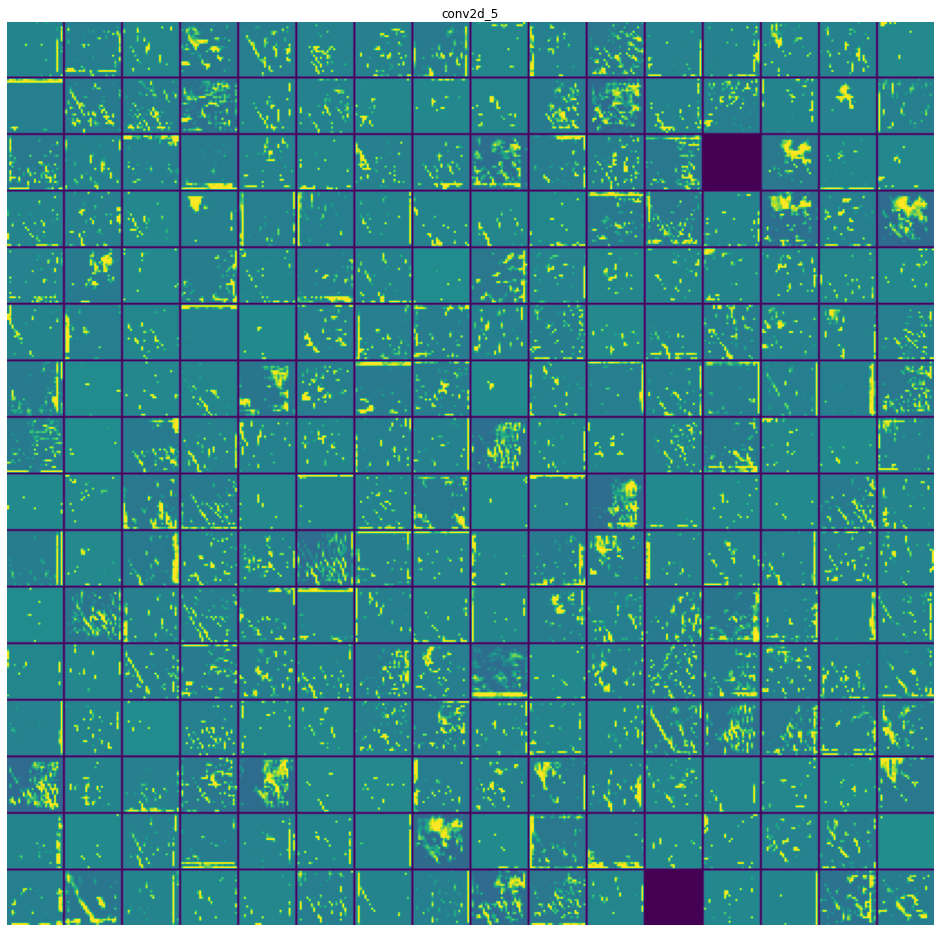

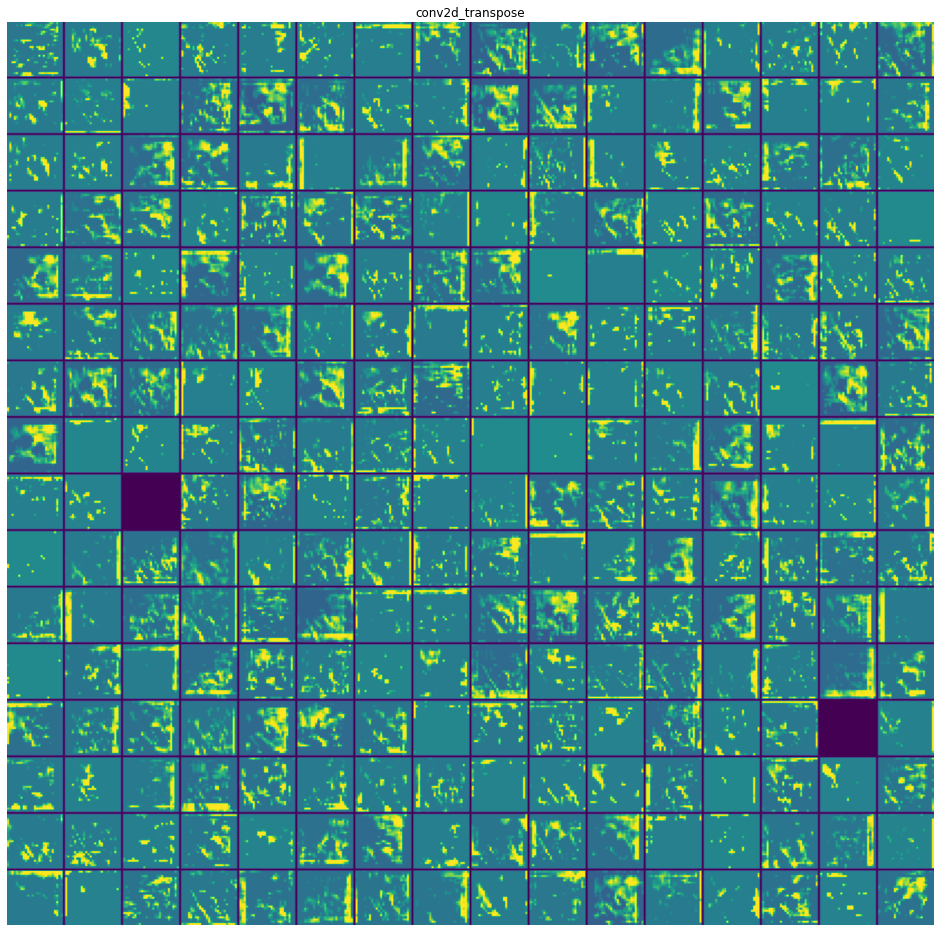

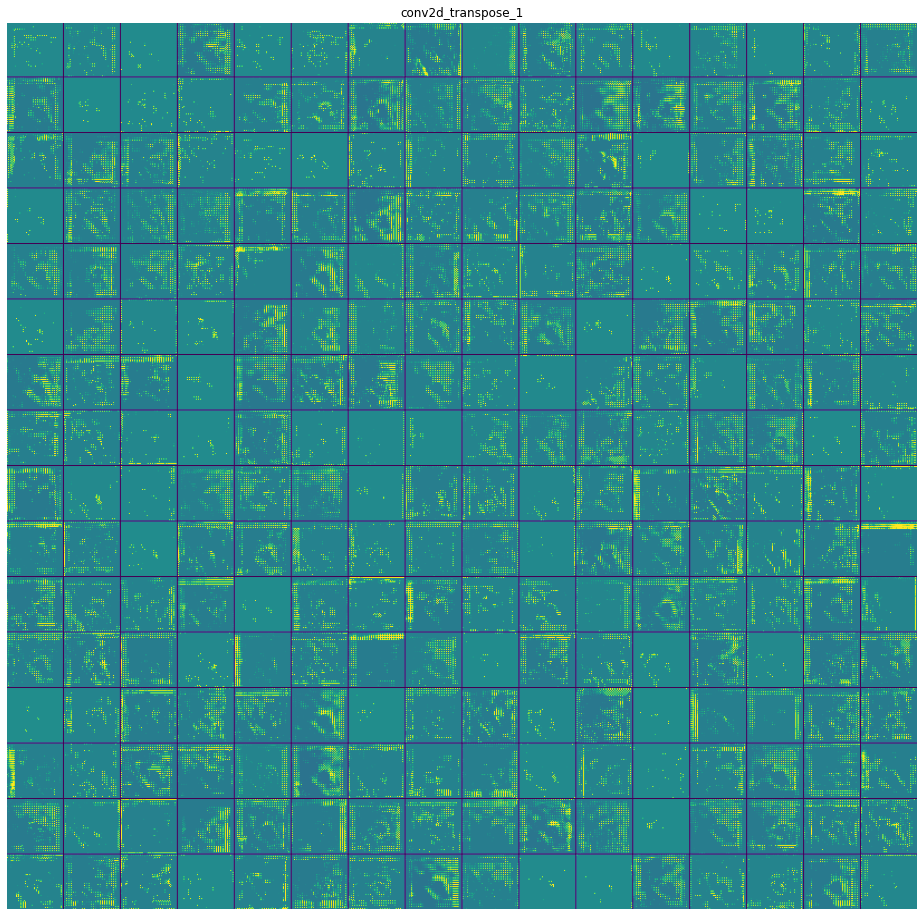

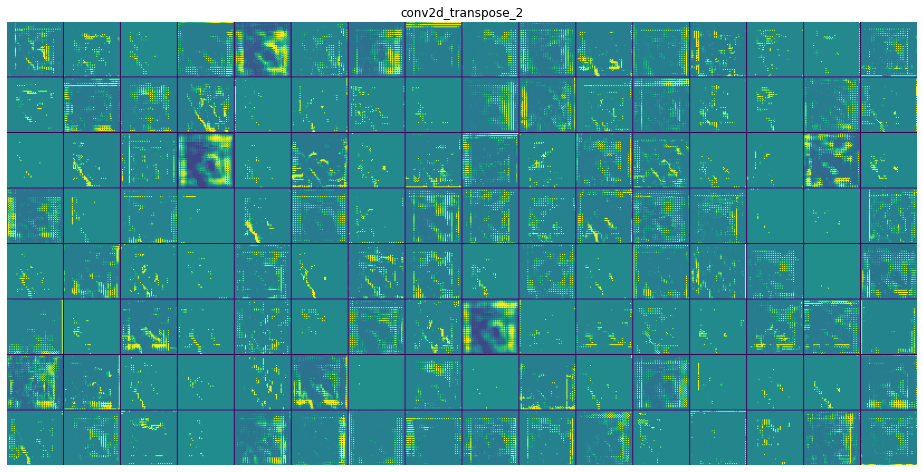

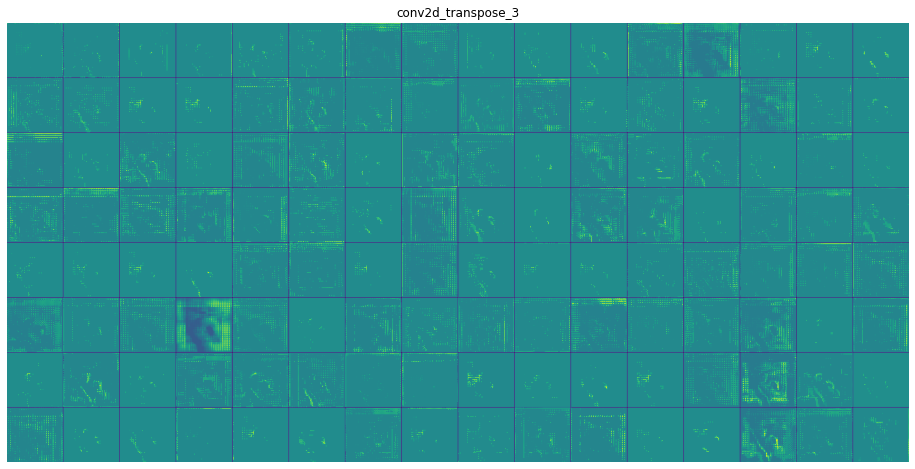

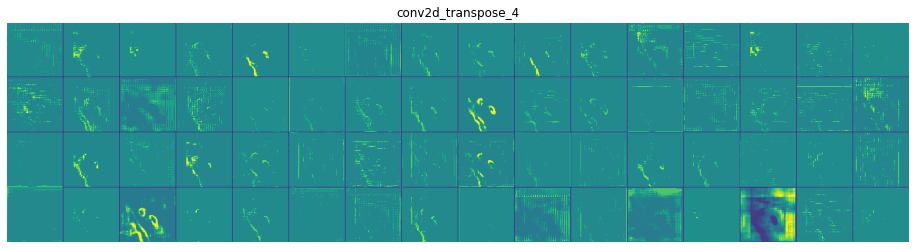

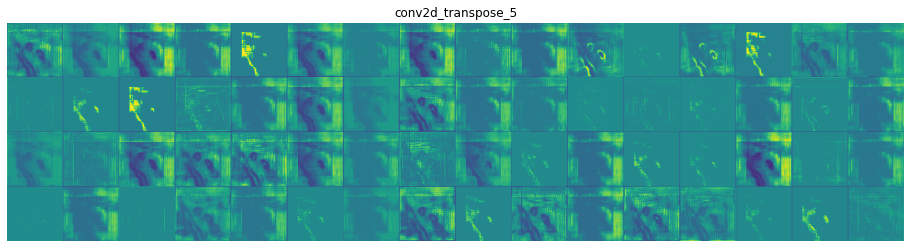

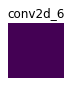

In [ ]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1]
  size = layer_activation.shape[1]
  n_cols = n_features // images_per_row
  if layer_name=="conv2d_6":
    display_grid = np.zeros(((size + 1),
                           1 * (size + 1) - 1))
  else:
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                            images_per_row * (size + 1) - 1))
  for col in range(n_cols):
    for row in range(images_per_row):
      channel_index = col * images_per_row + row
      channel_image = layer_activation[0, :, :, channel_index].copy()
      if channel_image.sum() != 0:
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype("uint8")
        display_grid[
        col * (size + 1): (col + 1) * size + col,
        row * (size + 1) : (row + 1) * size + row] = channel_image
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.axis("off")
  plt.imshow(display_grid, aspect="auto", cmap="viridis")

The first convolutional layer has very surface-level activations, which mostly resemble the input image. One could interpret its purpose as identifying all the edges in the photo, which may have various thicknesses, lengths, and angles.

The subsequent convolutional layers are more difficult to intepret. In theory, they are encoding more highly specific patterns, such as the body parts of the animals.